## Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

## Load Data

In [3]:
firebase_data = 'data/data.json'
with open(firebase_data, 'r') as infile:
    data = json.load(infile)
query_ids = list(data.keys())

In [4]:
assessor_info = 'data/assessor_info.tsv'
assessor_df = pd.read_csv(assessor_info,delimiter='\t',encoding='utf-8',header=None)
assessor_df.columns = ["user_id","email","consent","contact","english","progress","assessed_queries"]

## Create DataFrames per Query

In [5]:
def create_labels(nr_assessors):
    labels = ["query_id","passageid","msmarco"]
    for i in range(nr_assessors):
        labels = labels + ['user%s_id'%(i+1),'user%s_label'%(i+1)]
    return labels

In [6]:
dataframe_data = {}
label_data = {}
assessor_data = {}
for query_id in query_ids:
    query_data_lists = []
    query_data = data[query_id]
    nr_assessors = 0
    for i, passage_id in enumerate(query_data.keys()):
        dataFrameRow2be = [query_id, passage_id] + query_data[passage_id]
        query_data_lists.append(dataFrameRow2be)
        if i == 0:
            nr_assessors = int((len(query_data[passage_id])-1)/2)
    dataframe_data[query_id] = query_data_lists
    label_data[query_id] = create_labels(nr_assessors)
    assessor_data[query_id] = nr_assessors

In [7]:
dataframes = {}
for query_id in query_ids:
    df = pd.DataFrame(dataframe_data[query_id],columns=label_data[query_id])
    dataframes[query_id] = df

## Fix Missing Data

In [23]:
del dataframes['993153']['user2_label']
del dataframes['993153']['user2_id']

In [24]:
assessor_data['993153'] = 6

In [25]:
nr_assessors = assessor_data['993153']
user_column_names = []
for i in range(nr_assessors):
    user_column_names = user_column_names + ["user%s_id"%(i+1), "user%s_label"%(i+1)]
dataframes['993153'].columns = ['query_id','passageid','msmarco'] + user_column_names

## Gather Experiment Queries

In [8]:
experiment_query_ids = []
with open("output/experiment_queries.txt", "r") as infile:
    for line in infile:
        experiment_query_ids.append(line.rstrip())

## Assessor Statistics

1. How many assessors contributed?

In [9]:
assessor_ids = []
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_id"%(i+1) for i in range(nr_assessors)]
    for user_id_column in user_id_columns:
        user_id = list(np.unique(df[user_id_column].values.tolist()))[0]
        if not user_id in assessor_ids:
            assessor_ids.append(user_id)

In [10]:
print("The number of assessors is %s."%(len(assessor_ids)))

The number of assessors is 37.


2. How was there English level?

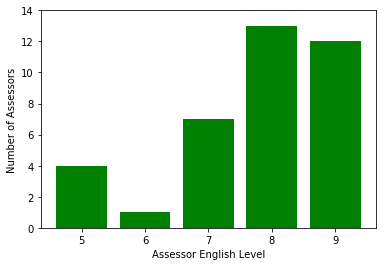

In [12]:
english_levels = assessor_df['english'].values.tolist()
level_counts = Counter(english_levels)
plt.bar(list(level_counts.keys()), level_counts.values(), color='g')
plt.xlabel("Assessor English Level")
plt.ylabel("Number of Assessors")
plt.ylim([0,14])
plt.savefig('images/assessor_english_distribution.png', bbox_inches='tight')
plt.show()

3. Did any low English level (<=6) assessors assess the same query?

We will need to filter on the assessors with an english level of below 7 and see if they assessed the same queries.

In [13]:
import ast

low_level_assessors_df = assessor_df[assessor_df['english'] < 7]

query_assessor_dict = {}

for index, row in low_level_assessors_df.iterrows():
    user_id = row['user_id']
    assessed_queries = ast.literal_eval(row['assessed_queries'])
    for query_id in assessed_queries:
        if not query_id in query_assessor_dict.keys():
            query_assessor_dict[query_id] = [user_id]
        else:
            qeury_assessor_dict[query_id].append(user_id)

In [14]:
query_assessor_dict

{'1006199': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1007473': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1040461': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1045227': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1046648': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1056446': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1065558': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1077356': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1083663': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1083852': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1085457': ['v1PE6B964Jd7CdtcUM26gX1giwe2'],
 '1088541': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1091688': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1095278': ['v1PE6B964Jd7CdtcUM26gX1giwe2'],
 '117113': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '149161': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '178468': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '202306': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '208494': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '231877': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '30860': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '321951': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'

As you can see each query only has one low english level user id connected to it. This means that no query id has been assessed by more than 1 low level english assessor.

4. How many queries did each assessor assess?

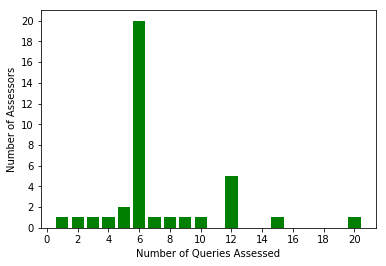

In [15]:
progress_numbers = assessor_df['progress'].values.tolist()
progress_counter = Counter(progress_numbers)
plt.bar(list(progress_counter.keys()), progress_counter.values(), color='g')
plt.xlabel("Number of Queries Assessed")
plt.ylabel("Number of Assessors")
plt.xticks(np.arange(0, 22, 2.0))
plt.yticks(np.arange(0, 22, 2.0))
plt.savefig('images/assessor_queries_assessed.png', bbox_inches='tight')
plt.show()

5. How many queries are assessed by low English level assessors?

In [16]:
queries_assessed_by_low_english_level_assessors = []
for index, row in low_level_assessors_df.iterrows():
    user_id = row['user_id']
    assessed_queries = ast.literal_eval(row['assessed_queries'])
    for query_id in assessed_queries:
        if not query_id in queries_assessed_by_low_english_level_assessors:
            queries_assessed_by_low_english_level_assessors.append(query_id)

In [17]:
print("There are %s queries assessed by low English level assessors."%(len(queries_assessed_by_low_english_level_assessors)))

There are 40 queries assessed by low English level assessors.


6. What is the number of assessors per query?

In [26]:
assessor_counts = Counter(list(assessor_data.values()))
print(assessor_counts)

Counter({1: 57, 3: 41, 2: 17, 5: 5, 6: 3, 4: 1, 7: 1})


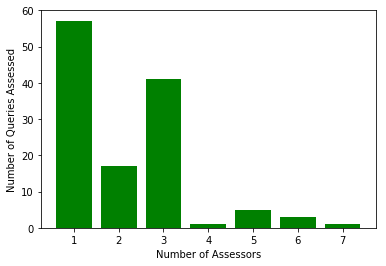

In [27]:
plt.bar(list(assessor_counts.keys()), assessor_counts.values(), color='g')
plt.xlabel("Number of Assessors")
plt.ylabel("Number of Queries Assessed")
plt.ylim([0,60])
plt.savefig('images/assessor_query_assessment_distribution.png', bbox_inches='tight')
plt.show()

7. What is the number of assessors per experiment query?

In [28]:
experiment_assessor_data = {}
for query_id in experiment_query_ids:
    experiment_assessor_data[query_id] = assessor_data[str(query_id)]

In [29]:
experiment_assessor_counts = Counter(list(experiment_assessor_data.values()))
print(experiment_assessor_counts)

Counter({3: 34, 5: 3, 4: 1, 6: 1, 7: 1})


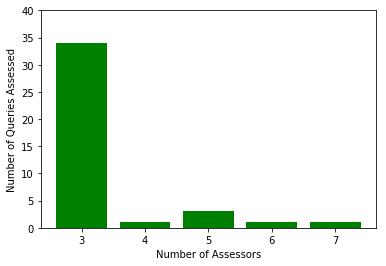

In [30]:
plt.bar(list(experiment_assessor_counts.keys()), experiment_assessor_counts.values(), color='g')
plt.xlabel("Number of Assessors")
plt.ylabel("Number of Queries Assessed")
plt.ylim([0,40])
plt.savefig('images/assessor_experiment_query_assessment_distribution.png', bbox_inches='tight')
plt.show()

Get assessor ids that helped to assess the experiment queries

In [31]:
assessor_ids = []
for query_id in experiment_query_ids:
    for index, row in assessor_df.iterrows():
        if str(query_id) in row['assessed_queries']:
            if not row['user_id'] in assessor_ids:
                assessor_ids.append(row['user_id'])

In [33]:
len(assessor_ids)

36